# Feature figures and stats

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# parameters
phenotype = 'group'
model_suffix = '_site_confounds_removed'
denoise = 'simple+gsr'
n_batch = 200
n_batch_null = 1000
weight_type = 'prediction'
n_targets = 10

# load results
df_list = []
for model in ['multilayer_metamatch']:
    in_file = (f"../results/feature_analysis/pathway_phenotype-{phenotype}_"
            f"model-{model}{model_suffix}_denoise-{denoise}_"
            f"n_batch-{n_batch}_n_batch_null-{n_batch_null}_"
            f"weight_type-{weight_type}_n_targets-{n_targets}.csv")
    df = pd.read_csv(in_file)
    df['model_label'] = model
    df_list.append(df)
df_all = pd.concat(df_list)
df_all.head()

,roi,value,model,iteration,model_label
0,NAc-shell,-0.000449,model,0.0,multilayer_metamatch
1,NAc-shell,-0.000259,model,1.0,multilayer_metamatch
2,NAc-shell,0.000100,model,2.0,multilayer_metamatch
3,NAc-shell,0.001284,model,3.0,multilayer_metamatch
4,NAc-shell,-0.001430,model,4.0,multilayer_metamatch


## Perform stats

In [2]:
# percentile based statistical analysis
results = pd.DataFrame()
r_factor = 1000
for model_label in ['multilayer_metamatch']:
    print(model_label)
    df = df_all.loc[df_all.model_label == model_label]
    for roi in df.roi.unique():
        data = df.loc[(df.roi == roi) & (df.model == 'model'), 'value']
        median = np.round(data.median()* r_factor, 2) 

        quantile_low = np.round(data.quantile(0.25)* r_factor, 2)
        quantile_high = np.round(data.quantile(0.75)* r_factor, 2) 

        value = data.median()
        _results = pd.DataFrame()
        _results['Model'] = [model_label.capitalize()]
        _results['Pathway'] = roi
        _results['PFW'] = f"{median} ({quantile_low} - {quantile_high})"

        # calculate perms
        for null_model in ['permutation', 'SC-Cort', 'Cort-Cort']:
            null_distribution = df.loc[(df.roi == roi) &
                                    (df.model == null_model), 'value'].values
            
            percentile = (null_distribution < value).mean()
            
            p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
            _results[null_model] = percentile.copy()
        results = pd.concat([results, _results])

# Reformat for table
results.replace('NAc-shell','NAcc', inplace=True)
results.replace('PUT-VA','vPut', inplace=True)
results.replace('CAU-DA','dCaud', inplace=True)
results.replace('PUT-DP','dPut', inplace=True)
#results.to_csv('../results/SC_pathways.csv',index=False)
results.head(10)

multilayer_metamatch


,Model,Pathway,PFW,permutation,SC-Cort,Cort-Cort
0,Multilayer_metamatch,NAcc,0.2 (-0.37 - 0.74),0.9226,0.4836,0.7386
0,Multilayer_metamatch,dCaud,-2.77 (-3.55 - -1.96),0.0124,0.0216,0.1640
0,Multilayer_metamatch,dPut,-2.33 (-2.93 - -1.71),0.0076,0.0390,0.2326
0,Multilayer_metamatch,vPut,-1.96 (-2.57 - -1.41),0.0098,0.0668,0.2914


In [3]:
model = "multilayer_metamatch"
in_file = (f"../results/feature_analysis/UKBB_phenotype-{phenotype}_"
        f"model-{model}{model_suffix}_denoise-{denoise}_"
        f"n_batch-{n_batch}_n_batch_null-{n_batch_null}.csv")
df = pd.read_csv(in_file)

# isolate just the stats
stats = df.loc[(df.iteration==0) & (df.fold==0) & (df.permutation == False)]

# create a supplementary table
stats = stats[['component', "percentile", "p_fdr"]]
stats["value"] = np.nan

# calculate medians and quantiles
r_factor = 1000
for comp in stats.component.unique():
        data = df.loc[(df.component == comp) & (df.permutation == False), "value"]
        median = np.round(data.median()*r_factor, 2) 
        quantile_low = np.round(data.quantile(0.25)*r_factor, 2)
        quantile_high = np.round(data.quantile(0.75)*r_factor, 2) 
        stats.loc[stats.component==comp, "value"] = f"{median} ({quantile_low} - {quantile_high})"

# sort by p value
stats = stats.sort_values('p_fdr')
print(sum(stats.p_fdr < 0.05))

if model == "multilayer_metamatch":
    # split the krr vs. DNN, DNN stacking (is the KRR also "stacking"?)
    stats[['source', 'component']] = stats['component'].str.split('_', n=1, expand=True)

    # split the dataset names
    stats[['dataset', 'component']] = stats['component'].str.split('_', n=1, expand=True)

    stats["method"] = stats["source"].copy()
    stats.loc[(stats.dataset=='UKBB') 
            & (stats.source == '0'), "method"] = "FC DNN"
    stats.loc[(stats.dataset=='UKBB') 
            & (stats.source == '1'), "method"] = "FC KRR"

    for ds in ['ABCD', 'GSP', 'HBN', 'eNKI']:
        stats.loc[(stats.dataset==ds) 
                & (stats.source == '0'), "method"] = "FC KRR"

        stats.loc[(stats.dataset==ds) 
                & (stats.source == '1'), "method"] = "DNN KRR (stacking)"
    stats = stats[["dataset", "method", "component", "value", "percentile", "p_fdr"]]
stats.round(3).to_csv(f"../results/{model}_weights.csv", index=False)
stats.head(10)


2


,dataset,method,component,value,percentile,p_fdr
231000,HBN,FC KRR,NIH7_Card,-23.56 (-25.82 - -20.6),0.0000,0.000000
232000,HBN,FC KRR,NIH7_Flanker,-25.11 (-27.93 - -22.05),0.0000,0.000000
286000,eNKI,FC KRR,DKEFSCWI_14,12.55 (11.47 - 13.67),0.9994,0.054960
200000,HBN,FC KRR,SDQ_Peer_Problems,14.33 (12.65 - 16.11),0.9994,0.054960
186000,GSP,FC KRR,TCI_HarmAvoidance,17.38 (15.84 - 18.88),0.9996,0.054960
130000,UKBB,FC KRR,BP_eye_C5,27.39 (23.9 - 30.57),0.9982,0.058886
88000,UKBB,FC KRR,Digit-o_C6,-6.09 (-6.77 - -5.31),0.0018,0.058886
278000,eNKI,FC KRR,VF_41,12.1 (10.76 - 13.43),0.9986,0.058886
266000,eNKI,FC KRR,WIAT_06,4.82 (4.32 - 5.31),0.9984,0.058886
201000,HBN,FC KRR,SDQ_Prosocial,-7.17 (-8.42 - -6.0),0.0018,0.058886


## Plot of SC pathways + mm weights

In [4]:
import nibabel as nb
import hcp_utils as hcp
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr
import matplotlib as mpl
import seaborn as sns
parc_file = "/home/lukeh/LabData/Lab_LucaC/Luke/Backups/hpc_backups/parcellations/Tian2020MSA_2023/3T/Cortex-Subcortex/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S4.dlabel.nii"


def create_hist_cbar(input_data, save=None, cmap=cmr.prinsenvlag_r):
    nbins = 40
    maxbin = np.max(abs(input_data))
    minbin = maxbin*-1

    data = input_data.copy()
    bins = np.linspace(minbin, maxbin, nbins)

    #cmap = cmr.prinsenvlag_r
    norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
    colors = cmap(np.linspace(0., 1., nbins))

    hist, bin_edges = np.histogram(data, bins)

    fig = plt.figure(figsize=(3,2))
    ax = fig.add_axes([0.05, 0.105, 0.9, 0.15])
    ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.05])

    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.ax.tick_params(labelsize=9)
    cb1.outline.set_visible(False)
    ax.bar(bin_edges[:-1], hist, width=0.005, color=colors, alpha=1.0)
    ax.set_xlim((minbin, maxbin))
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    if save is not None:
        plt.savefig(save+'_colorbar.jpeg', dpi=600)
    plt.show()


def pub_surf_plot(input_array, input_array2, parcellation, threshold=None, cmap=cmr.prinsenvlag_r, save=None):

    vmax = np.max(abs(input_array))
        
    # a very quick nilearn plot
    parc = np.squeeze(nb.load(parcellation).get_fdata())
    output = np.zeros((parc.shape))
    output2 = np.zeros((parc.shape))
    parcels = np.unique(parc)
    parcels = np.delete(parcels, 0)  # assume 0 denotes no roi

    for i in parcels:
        index = (parc==i)
        output[index] = input_array[int(i)-1]
        output2[index] = input_array2[int(i)-1]

    
    count = 1
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:
        
            if hemi == 'left':
                surface = hcp.left_cortex_data(output)
                surface2 = hcp.left_cortex_data(output2)
                mesh = hcp.mesh.inflated_left
                bg_map = hcp.mesh.sulc_left

            elif hemi == 'right':
                surface = hcp.right_cortex_data(output)
                surface2 = hcp.right_cortex_data(output2)
                mesh = hcp.mesh.inflated_right
                bg_map = hcp.mesh.sulc_right

            #fig, ax = plt.figure(figsize=(3, 3))
            
            plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap,
                                        hemi=hemi, bg_on_data=True, darkness=0.75, threshold=threshold,
                                        alpha=1, vmax=vmax, colorbar=False)
            ax = plt.gca()               
            for roi in np.unique(surface2)[1::]:
                try:
                    plotting.plot_surf_contours(mesh, surface2, levels=[int(roi)], bg_map=bg_map, view=view, colors='k', hemi=hemi, bg_on_data=True, darkness=0.50, axes=ax)
                except:
                    print("contour not plotting", hemi, view)
            count = count+1
            if save is not None:
                plt.savefig(save+'_'+hemi+'_'+view+'.jpeg', dpi=600)
    plt.show()


def get_cropped_img(img,
                    x_start_buffer=10,
                    x_finish_buffer=10,
                    y_start_buffer=10,
                    y_finish_buffer=10,
                    ):
    # Returns a cropped input image

    # average across color information (3rd dimension)
    m_img = np.mean(img, axis=2)

    x_start = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][0] ) - x_start_buffer
    x_finish = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][-1]) + x_finish_buffer
    y_start = np.where(np.argmax(m_img != np.max(img), axis=1))[0][0] - y_start_buffer
    y_finish = np.where(np.argmax(m_img != np.max(img), axis=1))[0][-1] + y_finish_buffer

    # Crop the input image based on determined crop heights and widths
    img_cropped = img[y_start:y_finish, x_start:x_finish, :]
    return img_cropped

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [5]:
# parametrs
in_data = "/home/lukeh/LabData/Lab_LucaC/HumanConnectomeProject/derivatives/fc/"
label_file = "/home/lukeh/LabData/Lab_LucaC/Luke/Backups/hpc_backups/parcellations/Tian2020MSA_2023/3T/Cortex-Subcortex/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S4_label.txt"
n_rois = 454
n_targets = 10

parcel_labels = []
with open(label_file, 'r') as f:
    for count, line in enumerate(f, start=0):
        if count % 2 == 0:
            parcel_labels.append(line.split('\n')[0])
plot_data_arrays = np.zeros((n_rois, 4))
count = 0
for seed_a, seed_b in zip([23, 12, 17, 15], [50, 39, 44, 42]):
    
    # get seed-specific data
    print(parcel_labels[seed_a])
    seed_a_data = np.loadtxt(f"../results/HCP_roi/{parcel_labels[seed_a]}_{seed_a}_fc_rvals_parc-order.csv", delimiter=',')
    seed_b_data = np.loadtxt(f"../results/HCP_roi/{parcel_labels[seed_b]}_{seed_b}_fc_rvals_parc-order.csv", delimiter=',')

    # average the data across hemisphere seeds
    # (too many plots otherwise)
    avg_data = np.mean(np.vstack((seed_a_data, seed_b_data)), axis=0)
    #avg_data = np.max(np.vstack((seed_a_data, seed_b_data)), axis=0)
    # plot the unthresholded data
    plot_data = np.zeros((454))
    plot_data[54::] = avg_data.copy()
    plot_data_arrays[:, count] = plot_data.copy()
    # plot thresholded data
    plot_data_threshold = np.zeros((454))
    file_a = f"../results/HCP_roi/{parcel_labels[seed_a]}_{seed_a}_fc_tvals_sorted.csv"
    file_b = f"../results/HCP_roi/{parcel_labels[seed_b]}_{seed_b}_fc_tvals_sorted.csv"
    rois = np.stack((np.loadtxt(file_a, delimiter=',')[0:n_targets].astype(int),
            np.loadtxt(file_b, delimiter=',')[0:n_targets].astype(int))).flatten()

    plot_data_threshold[rois+54] = rois+54
    # pub_surf_plot(plot_data, plot_data_threshold, parc_file,
    #               save="../results/figures/HCP/"+parcel_labels[seed_a])

    count = count + 1
    #plt.hist(plot_data)
    #plt.show()

NAc-shell-rh
PUT-VA-rh
CAU-DA-rh
PUT-DP-rh


/tmp/ipykernel_3909821/1331294448.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=data,
/tmp/ipykernel_3909821/1331294448.py:150: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(data=data,
/tmp/ipykernel_3909821/1331294448.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Null model"])
/tmp/ipykernel_3909821/1331294448.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_label'].replace('logreg','BLR', inplace=True)
/tmp/ipykernel_3909821/1331294448.py:180: SettingWithCopyWarning: 
A value is trying to be set on 

['Flanker test (NIH)' 'Card sorting (NIH)' 'Harm avoidance (TCI)'
 'CWI (D-KEFS, item 14)' 'Peer problems (SDQ)' 'Verbel fluency (D-KEFS)'
 'CWI (D-KEFS, item 18)' 'Behavioural drive (BIS-BAS)' 'Sleep per day'
 'Academic skills (WIAT)']


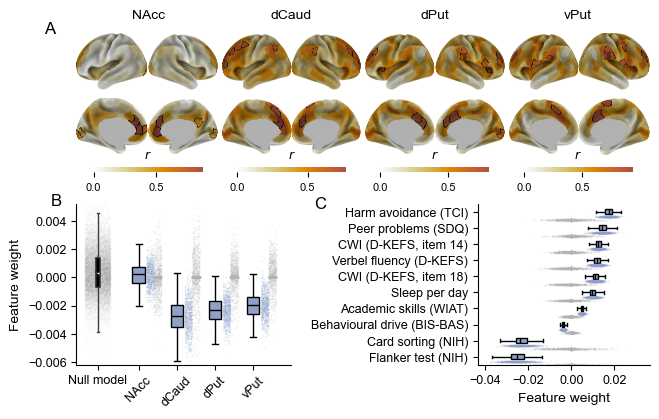

In [55]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

# gridspec inside gridspec
fig = plt.figure(figsize=(7.4, 4.5))

# create gridspec between brains and scatter plot
gs0 = gridspec.GridSpec(4, 1, height_ratios=(0.01, 0.4, 0.09, 0.5),
                        figure=fig, hspace=0.1, wspace=0)

# Create gridspec for titles
gs_titles = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0],
                                        hspace=0, wspace=0)
for i, title in enumerate(['NAcc', 'dCaud', 'dPut', 'vPut']):
    ax = fig.add_subplot(gs_titles[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, 0, title, ha="center", va="bottom", fontsize=10)
    sns.despine(left=True, bottom=True, ax=ax)

# create nested gridspec for brains
gs00 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs0[1],
                                        hspace=0, wspace=0)

count = 0
for view in ['lateral', 'medial']:
    for roi in ['NAc-shell-rh', 'CAU-DA-rh', 'PUT-VA-rh', 'PUT-DP-rh']:
        for hemi in ['left', 'right']:

            # get image
            img = plt.imread(f"../results/figures/HCP/{roi}_{hemi}_{view}.jpeg")
            x_start_buffer = np.nan
            x_finish_buffer = np.nan

            if count == 7 or count == 15:
                x_start_buffer = 5
                x_finish_buffer = 0

            elif count % 2 != 0:
                x_finish_buffer = 50
                x_start_buffer = 5

            if count == 0 or count == 8:
                x_start_buffer = 0
                x_finish_buffer = 5

            elif count % 2 == 0:
                x_start_buffer = 50
                x_finish_buffer = 5

            img_cropped = get_cropped_img(img,
                                          x_start_buffer=x_start_buffer,
                                          x_finish_buffer=x_finish_buffer,
                                          y_start_buffer=1,
                                          y_finish_buffer=1)
            
            # get ax
            ax = fig.add_subplot(gs00[count])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped, aspect='equal')
            sns.despine(left=True, bottom=True, ax=ax)
            if count == 0:
                ax.text(-0.45, 1.0, "A", fontsize=12, ha='left', transform=ax.transAxes)
            count = count+1

# Create gridspec for colorbars

x = (3, 19, 6, 19, 6, 19, 6, 19, 3)
gs_bars = gridspec.GridSpecFromSubplotSpec(5, 9,
                                           width_ratios=x,
                                           subplot_spec=gs0[2],
                                           hspace=0, wspace=0)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# minColor = 0.00
# maxColor = 0.85
cmap = truncate_colormap(cmr.prinsenvlag_r, 0.5, 1.0)
count = 0
for i in range(9):
    ax = fig.add_subplot(gs_bars[i])
    if i in [1, 3, 5, 7]:
        maxbin = np.max(abs(plot_data_arrays[:, count]))
        minbin = 0 #maxbin*-1
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
        cb1.ax.tick_params(labelsize=8)
        cb1.ax.locator_params(nbins=3)
        cb1.outline.set_visible(False)
        ax.set_title('$\it{r}$', fontsize=9)
        sns.despine(ax=ax, left=True, bottom=True)
        count = count+1
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)

# Create gridspec for bottom graphs         
gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=(.5, .1, .4), wspace=0.5,
                                        subplot_spec=gs0[3])

# Create a gridspec inside the gridspec yo
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=(.2, .8),
                                        subplot_spec=gs01[0], hspace=0, wspace=0)

ax = fig.add_subplot(gs02[0])
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Null model boxplots
pal = ['grey', 'grey']
ylims = (-0.0062, 0.0052)

df = df_all.copy()
df['desc'] = df['roi'].copy()
df.loc[df.model =='permutation', "desc"] = "permutation"
df.loc[df.model =='SC-Cort', "desc"] = "SC-Cort"
df.loc[df.model =='Cort-Cort', "desc"] = "Cort-Cort"

# Plot the null models first.
data = df.loc[(df.model != 'model') & (df.desc == "SC-Cort")]
quantile_data = data.copy()
sns.boxplot(data=data,
            ax=ax,
            x="desc",
            y='value',
            zorder=1,
            legend=False,
            notch=True,
            showfliers=False,
            boxprops={"facecolor": 'k'},
            medianprops={"color": "w", "linewidth": 1},
            width=0.10,
            )

sns.stripplot(data=data,
              ax=ax,
              y='value',
              x='desc',
              palette=pal,
              dodge=False,
              zorder=0,
              size=1,
              alpha=0.025,
              jitter=0.3,
              legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.yaxis.offsetText.set_fontsize(8)
ax.set_ylabel("Feature weight", fontsize=10)
ax.set_xlabel("")
sns.despine(ax=ax)
ax.set_ylim(ylims)
ax.set_xticklabels(["Null model"])
ax.text(-0.6, 0.99, "B", fontsize=12, ha='left',transform=ax.transAxes)
#t = ax.yaxis.get_offset_text()
#t.set_x(-0.1)

# plot actual model
ax = fig.add_subplot(gs02[1])
pal = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[7]]
df = df_all.copy()
data = df.loc[df.model == 'model']
data['model_label'].replace('logreg','BLR', inplace=True)
data['model_label'].replace('multilayer_metamatch','MM', inplace=True)
data['roi'].replace('NAc-shell','NAcc', inplace=True)
data['roi'].replace('PUT-VA','vPut', inplace=True)
data['roi'].replace('CAU-DA','dCaud', inplace=True)
data['roi'].replace('PUT-DP','dPut', inplace=True)
#data = data.groupby(['roi', 'model_label']).mean()

sns.boxplot(data=data,
            ax=ax,
            x="roi",
            y='value',
            order=['NAcc', 'dCaud', 'dPut', 'vPut'],
            color=pal[0],
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.2,
            zorder=2,
            legend=False)

sns.stripplot(data=data,
            ax=ax,
            x="roi",
            y='value',
            order=['NAcc', 'dCaud', 'dPut', 'vPut'],
            color=pal[0],
            dodge=True,
            zorder=5,
            size=1,
            alpha=0.15,
            jitter=0.10,
            legend=False)

# permutations
df = df_all.copy()
data = df.loc[df.model == 'permutation']
data['model_label'].replace('logreg','LR', inplace=True)
data['model_label'].replace('multilayer_metamatch','MM', inplace=True)
data['roi'].replace('NAc-shell','NAcc', inplace=True)
data['roi'].replace('PUT-VA','vPut', inplace=True)
data['roi'].replace('CAU-DA','dCaud', inplace=True)
data['roi'].replace('PUT-DP','dPut', inplace=True)
sns.stripplot(data=data,
              ax=ax,
              x="roi",
              y='value',
              order=['NAcc', 'dCaud', 'dPut', 'vPut'],
              color=pal[1],
              zorder=0,
              size=1,
              alpha=0.15,
              jitter=0.10,
              legend=False)

offsets = [0.3, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5, 0.5]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([off, 0]))

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("")
ax.set_yticks([])
ax.set_ylim(ylims)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("")
ax.set_xlim([-0.5, 4])
sns.despine(ax=ax, left=True)

# UKBB plot
ax = fig.add_subplot(gs01[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True, ax=ax)
ax = fig.add_subplot(gs01[2])
n_components = 10
in_file = (f"../results/feature_analysis/UKBB_phenotype-{phenotype}_"
        f"model-multilayer_metamatch{model_suffix}_denoise-{denoise}_"
        f"n_batch-{n_batch}_n_batch_null-{n_batch_null}.csv")

df = pd.read_csv(in_file)

# Create human readable df
df.replace(to_replace='0_HBN_NIH7_Flanker',value="Flanker test (NIH)", inplace=True)
df.replace(to_replace='0_HBN_NIH7_Card',value="Card sorting (NIH)", inplace=True)
df.replace(to_replace='0_GSP_TCI_HarmAvoidance',value="Harm avoidance (TCI)", inplace=True)
df.replace(to_replace='0_eNKI_DKEFSCWI_14',value="CWI (D-KEFS, item 14)", inplace=True)
df.replace(to_replace='0_HBN_SDQ_Peer_Problems',value="Peer problems (SDQ)", inplace=True)
df.replace(to_replace='0_eNKI_VF_41',value="Verbel fluency (D-KEFS)", inplace=True)
df.replace(to_replace='0_eNKI_DKEFSCWI_18',value="CWI (D-KEFS, item 18)", inplace=True)
df.replace(to_replace='0_GSP_BISBAS_BAS_Drive',value="Behavioural drive (BIS-BAS)", inplace=True)
df.replace(to_replace='1_UKBB_Sleep',value="Sleep per day", inplace=True)
df.replace(to_replace='0_eNKI_WIAT_06',value="Academic skills (WIAT)", inplace=True)


# isolate just the stats
stats = df.loc[(df.iteration==0) & (df.fold==0) & (df.permutation == False)]
stats.head()

components_to_keep = stats.component.unique()[np.argsort(stats.p.values)][0:n_components]
print(components_to_keep)
plot_df = df.loc[(df.phenotype == phenotype)]
mask = plot_df.component.isin(components_to_keep)
plot_df = plot_df.loc[mask]

# second plot df
plot_df_mean = df.loc[(df.phenotype == phenotype)
                         & (df.permutation== False)]

mask = plot_df_mean.component.isin(components_to_keep)
plot_df_mean = plot_df_mean.loc[mask]

# Group by 'component' and calculate the mean value for each component
component_means = plot_df_mean.groupby('component')['value'].mean()

# Sort the components based on mean values in descending order
sorted_components = component_means.sort_values(ascending=False)

# Convert the sorted components to a list
component_list_by_magnitude = sorted_components.index.tolist()

sns.stripplot(data=plot_df.loc[plot_df.permutation == False],
              ax=ax,
              x="value",
              y='component',
              order=component_list_by_magnitude,
              color=pal[0],
              dodge=True,
              zorder=5,
              size=1,
              alpha=0.15,
              jitter=0.05,
              legend=False)

# permutations
sns.stripplot(data=plot_df.loc[plot_df.permutation==True],
              ax=ax,
              x="value",
              y='component',
              order=component_list_by_magnitude,
              color=pal[1],
              zorder=0,
              size=1,
              alpha=0.15,
              jitter=0.05,
              legend=False)

a = 0.3
b = 0.5
offsets = [a, a, a, a, a, a, a, a, a, a,
           b, b, b, b, b, b, b, b, b, b]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([0, off]))

sns.boxplot(data=plot_df.loc[plot_df.permutation==False],
            ax=ax,
            x="value",
            y='component',
            order=component_list_by_magnitude,
            color=pal[0],
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.2,
            zorder=2,
            legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("")
ax.text(-0.95, 0.97, "C", fontsize=12, ha='left', transform=ax.transAxes)
ax.set_xlabel("Feature weight", fontsize=10)
sns.despine(ax=ax)
plt.savefig('../results/figures/SC_pathways_mm.svg')
plt.savefig('../results/figures/SC_pathways_mm.jpeg', dpi=600, transparent=True)
plt.show()


In [7]:

'''
df.replace(to_replace="1_UKBB_BP_eye_C5",value="BP and eye (PC5)", inplace=True)
df.replace(to_replace="1_UKBB_Neuro",value="Neuroticism (EPIN-R)", inplace=True)
df.replace(to_replace="1_UKBB_BP_eye_C4",value="BP and eye (PC4)", inplace=True)

df.replace(to_replace="0_ABCD_cbcl_scr_syn_somatic_r",value="Somatic Complaints (CBCL)", inplace=True)

df.replace(to_replace="0_HBN_SRS_COG_T", value="Social cognition (SRS)", inplace=True)
df.replace(to_replace="0_HBN_SRS_AWR_T", value="Social awareness (SRS)", inplace=True)
df.replace(to_replace="0_HBN_SRS_RRB_T", value="RRB (SRS)", inplace=True)
df.replace(to_replace="0_HBN_NIH7_Pattern", value="Pattern Comparison (NIH)", inplace=True)
df.replace(to_replace="0_eNKI_DKEFSTMT_20",value="TMT (D-KEFS, item 20)", inplace=True)
df.replace(to_replace="0_eNKI_DKEFSTMT_18",value="TMT (D-KEFS, item 18)", inplace=True)
df.replace(to_replace="Body C3",value="Anthropometry (PC3)", inplace=True)
df.replace(to_replace="Time TV ",value="Time spent watching TV", inplace=True)
df.replace(to_replace="Sleep",value="Sleep duration", inplace=True)
df.replace(to_replace="BP eye C5",value="BP and eye (PC5)", inplace=True)
df.replace(to_replace="ECG C2",value="Electrocardiogram (PC2)", inplace=True)
df.replace(to_replace="Dur C2",value="Process duration (PC2)", inplace=True)
df.replace(to_replace="BP eye C6",value="BP and eye (PC6)", inplace=True)
df.replace(to_replace="Trail-o C3",value="Trail making task (PC3)", inplace=True)
df.replace(to_replace="Travel",value="Freq. work travel", inplace=True)
df.replace(to_replace="Age edu ",value="Age finished edu.", inplace=True)
'''

'\ndf.replace(to_replace="1_UKBB_BP_eye_C5",value="BP and eye (PC5)", inplace=True)\ndf.replace(to_replace="1_UKBB_Neuro",value="Neuroticism (EPIN-R)", inplace=True)\ndf.replace(to_replace="1_UKBB_BP_eye_C4",value="BP and eye (PC4)", inplace=True)\n\ndf.replace(to_replace="0_ABCD_cbcl_scr_syn_somatic_r",value="Somatic Complaints (CBCL)", inplace=True)\n\ndf.replace(to_replace="0_HBN_SRS_COG_T", value="Social cognition (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_SRS_AWR_T", value="Social awareness (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_SRS_RRB_T", value="RRB (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_NIH7_Pattern", value="Pattern Comparison (NIH)", inplace=True)\ndf.replace(to_replace="0_eNKI_DKEFSTMT_20",value="TMT (D-KEFS, item 20)", inplace=True)\ndf.replace(to_replace="0_eNKI_DKEFSTMT_18",value="TMT (D-KEFS, item 18)", inplace=True)\ndf.replace(to_replace="Body C3",value="Anthropometry (PC3)", inplace=True)\ndf.replace(to_replace="Time TV ",value="Time 